## **Credit Risk Prediction on South German Credit Dataset**

**MSc Data Science Project**

**Student:** *Imthiyaz Shaik*  
**Programme:** MSc Data Science  
**Module:** MSc Project / Dissertation   

---

## 1. Project Topic and Overview

This project investigates **credit risk prediction** using the **South German Credit** dataset, a corrected and well-documented version of the widely used Statlog German Credit data. The study focuses on evaluating machine learning models for classifying loan applicants as **good** or **bad** credit risks and compares models across four key dimensions:

1. **Predictive performance**  
2. **Misclassification cost**  
3. **Fairness across sensitive attributes (e.g. age, sex/personal status)**  
4. **Interpretability of model decisions**




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Dataset Chosen
### 2.1 South German Credit Dataset

- **Dataset name:** South German Credit (corrected German credit dataset)  
- **Rows:** 1,000 customers  
- **Columns:** 20 predictors + 1 target (`credit_risk`)  
- **Target variable:**  
  - `good` – applicant considered a good credit risk  
  - `bad` – applicant considered a bad credit risk  

The dataset is a corrected and better-documented version of the classical Statlog German Credit data. It provides information about loan applicants from a South German bank and is widely used in modern research on **credit scoring, fairness, and interpretability**.

In this notebook, we load a **decoded CSV version** where all categorical variables have human-readable labels (e.g. `"no checking account"`, `"rent"`, `"good"`, `"bad"`).

The dataset can be found on Kaggle on the following link https://www.kaggle.com/datasets/sid321axn/south-german-credit-updated


## 3. Background and Research Question

### 3.1 Background

Credit risk prediction is a core task in retail banking, where financial institutions must decide whether to **approve or reject loan applications**. Incorrect decisions have asymmetric consequences:

- Approving a **bad** borrower (false negative) can lead to **financial loss**.
- Rejecting a **good** borrower (false positive) may lead to **lost business** but smaller direct loss.

Beyond financial loss, there are also **ethical and regulatory concerns**. Models may unintentionally disadvantage groups defined by **age, gender, or marital status**. At the same time, regulatory frameworks increasingly demand **transparent and interpretable** models.

The South German Credit dataset offers a realistic setting to study these challenges using modern machine learning.

---

### 3.2 Research Question

> **How do different machine learning models perform in terms of predictive accuracy, misclassification cost, fairness across sensitive attributes, and interpretability when assessing credit risk using the South German Credit dataset?**

### 3.3 Aim

To evaluate, compare, and explain machine learning models for credit risk prediction by analysing **performance**, **misclassification cost**, **fairness**, and **interpretability** on the South German Credit dataset.

### 3.4 Key Objectives

1. Train and evaluate multiple machine learning models (e.g. Logistic Regression, Random Forest, Gradient Boosting) for credit risk prediction.
2. Quantify **misclassification costs**, with particular focus on the cost of misclassifying bad borrowers as good.
3. Assess **fairness** of the models across sensitive attributes such as **age** and **personal_status_sex**.
4. Investigate **feature importance and interpretability** using techniques such as permutation importance.
5. Recommend an overall modelling approach that balances performance, cost, fairness, and interpretability.


## 4. Brief Literature Review for discussion

> This is a short, non-exhaustive summary to show awareness of existing work.  
> A full literature review will be developed in the written report.

- **Classical credit scoring:** Many early studies used logistic regression and decision trees on German credit data to predict default and compare models.
- **Cost-sensitive learning:** Work on the German credit dataset has emphasised that misclassifying a bad borrower as good is several times more costly than the opposite, motivating cost-sensitive evaluation and threshold tuning.
- **Fairness and corrected data:** Recent research introduced the **South German Credit** dataset as a corrected version of Statlog German Credit, highlighting coding issues and enabling more reliable fairness analyses. Studies show that model performance and fairness can depend strongly on preprocessing choices.
- **Encoding and feature importance:** Several papers show that encoding strategies and feature selection can significantly affect both performance and fairness. Important predictors typically include checking account status, credit history, loan amount, duration, and savings.




# 5. Setup and Imports

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score,
    confusion_matrix,
    classification_report
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

In [ ]:
#  Load Dataset

df = pd.read_csv("/content/german_credit.csv")

df.head()


,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,no checking account,18,all credits at this bank paid back duly,car (used),1049,unknown/no savings account,< 1 yr,< 20,female : non-single or male : single,none,...,car or other,21,none,for free,1,skilled employee/official,0 to 2,no,no,good
1,no checking account,9,all credits at this bank paid back duly,others,2799,unknown/no savings account,1 <= ... < 4 yrs,25 <= ... < 35,male : married/widowed,none,...,unknown / no property,36,none,for free,3-Feb,skilled employee/official,3 or more,no,no,good
2,... < 0 DM,12,no credits taken/all credits paid back duly,retraining,841,... < 100 DM,4 <= ... < 7 yrs,25 <= ... < 35,female : non-single or male : single,none,...,unknown / no property,23,none,for free,1,unskilled - resident,0 to 2,no,no,good
3,no checking account,12,all credits at this bank paid back duly,others,2122,unknown/no savings account,1 <= ... < 4 yrs,20 <= ... < 25,male : married/widowed,none,...,unknown / no property,39,none,for free,3-Feb,unskilled - resident,3 or more,no,yes,good
4,no checking account,12,all credits at this bank paid back duly,others,2171,unknown/no savings account,1 <= ... < 4 yrs,< 20,male : married/widowed,none,...,car or other,38,bank,rent,3-Feb,unskilled - resident,0 to 2,no,yes,good


In [ ]:
# Quick shape and info
df.shape, df.dtypes


((1000, 21),
 status                     object
 duration                    int64
 credit_history             object
 purpose                    object
 amount                      int64
 savings                    object
 employment_duration        object
 installment_rate           object
 personal_status_sex        object
 other_debtors              object
 present_residence          object
 property                   object
 age                         int64
 other_installment_plans    object
 housing                    object
 number_credits             object
 job                        object
 people_liable              object
 telephone                  object
 foreign_worker             object
 credit_risk                object
 dtype: object)

## 6. Data Dictionary

The table below provides an initial data dictionary. This will be refined as needed.



In [ ]:
#  Build a simple data dictionary programmatically as a starting point

data_dict = pd.DataFrame({
    "column_name": df.columns,
    "description": [
        "Status of existing checking account",
        "Duration of credit (months)",
        "Credit history status",
        "Purpose of the credit (e.g., car, furniture, education)",
        "Credit amount",
        "Savings account/bonds status",
        "Employment duration category",
        "Installment rate as % of disposable income",
        "Combined personal status and sex",
        "Other debtors / guarantors",
        "Present residence time (years category)",
        "Property ownership / type",
        "Age in years",
        "Other installment plans (e.g., bank, stores, none)",
        "Housing situation (rent/own/free)",
        "Number of existing credits at this bank",
        "Job category",
        "Number of people liable to provide maintenance",
        "Telephone availability",
        "Foreign worker status",
        "Credit risk (target: good/bad)"
    ],
    "type": df.dtypes.astype(str).values
})

data_dict


,column_name,description,type
0,status,Status of existing checking account,object
1,duration,Duration of credit (months),int64
2,credit_history,Credit history status,object
3,purpose,"Purpose of the credit (e.g., car, furniture, e...",object
4,amount,Credit amount,int64
5,savings,Savings account/bonds status,object
6,employment_duration,Employment duration category,object
7,installment_rate,Installment rate as % of disposable income,object
8,personal_status_sex,Combined personal status and sex,object
9,other_debtors,Other debtors / guarantors,object


## 7. Exploratory Data Analysis (EDA)

We now explore the dataset to understand:

- Class balance of `credit_risk`
- Distribution of key numeric variables (age, amount, duration)
- Distribution of important categorical features (status, savings, housing)
- Initial fairness-relevant patterns (e.g., risk by sex/age group)


In [ ]:
#  Check missing values
df.isna().sum()


,0
status,0
duration,0
credit_history,0
purpose,0
amount,0
savings,0
employment_duration,0
installment_rate,0
personal_status_sex,0
other_debtors,0


In [ ]:
#  Target variable distribution
df["credit_risk"].value_counts(normalize=True)


,proportion
credit_risk,
good,0.7
bad,0.3


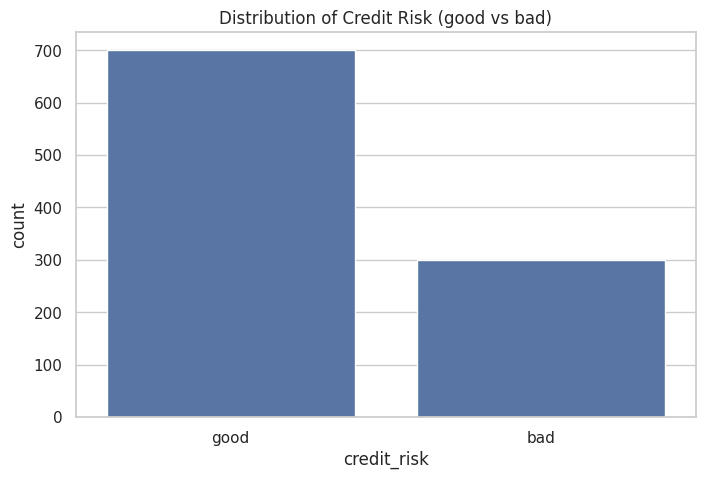

In [ ]:
#  Plot target distribution
sns.countplot(x="credit_risk", data=df)
plt.title("Distribution of Credit Risk (good vs bad)")
plt.show()


In [ ]:
#  Numeric features distribution

numeric_cols = ["amount", "duration", "age"]
df[numeric_cols].describe()


,amount,duration,age
count,1000.00000,1000.000000,1000.00000
mean,3271.24800,20.903000,35.54200
std,2822.75176,12.058814,11.35267
min,250.00000,4.000000,19.00000
25%,1365.50000,12.000000,27.00000
50%,2319.50000,18.000000,33.00000
75%,3972.25000,24.000000,42.00000
max,18424.00000,72.000000,75.00000


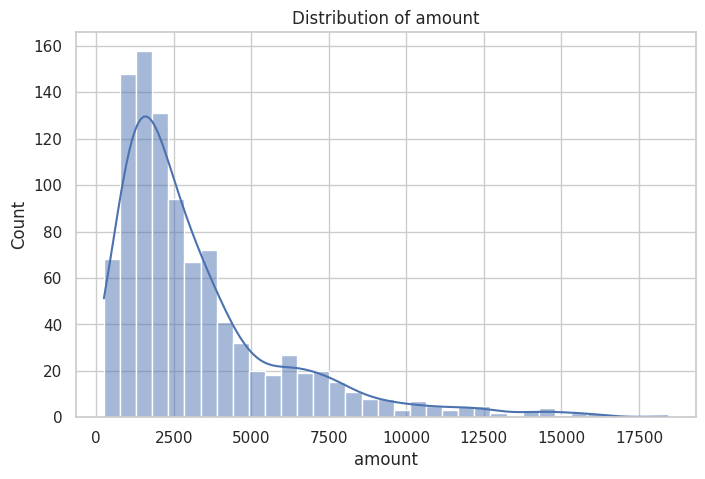

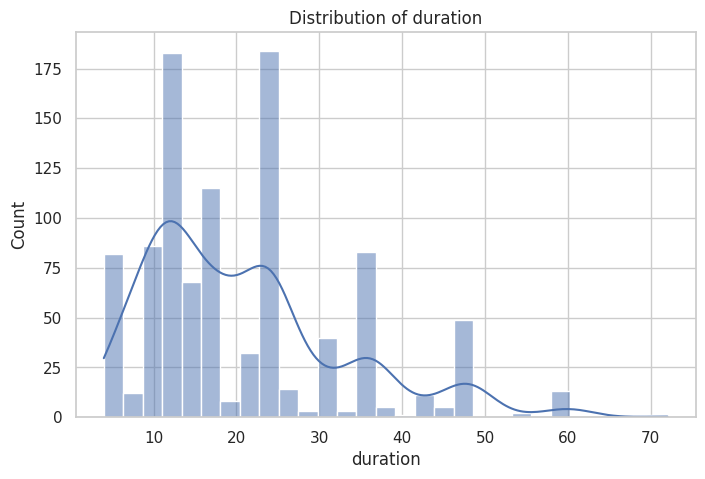

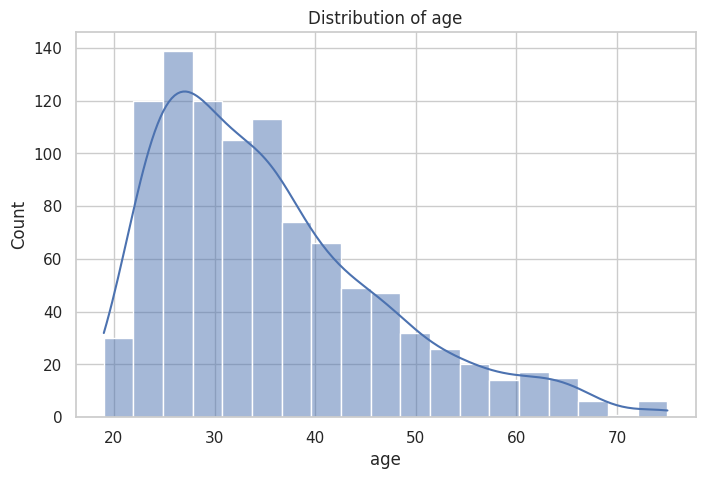

In [ ]:
for col in numeric_cols:
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


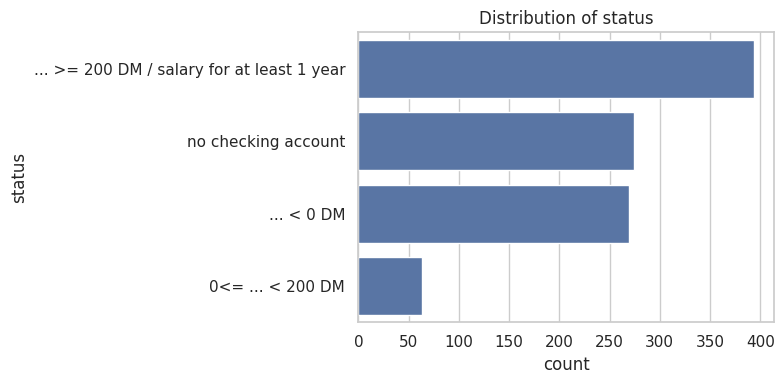

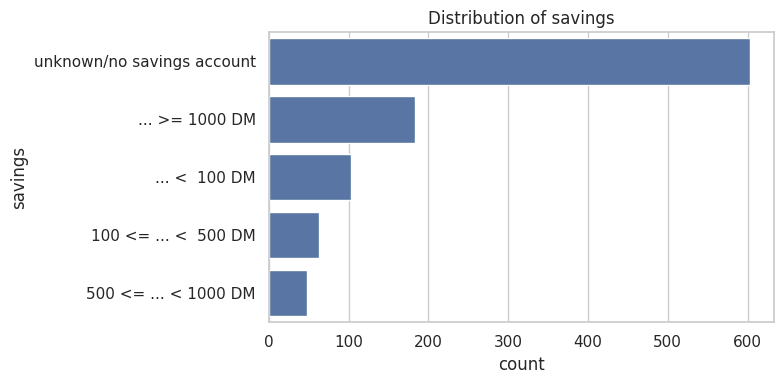

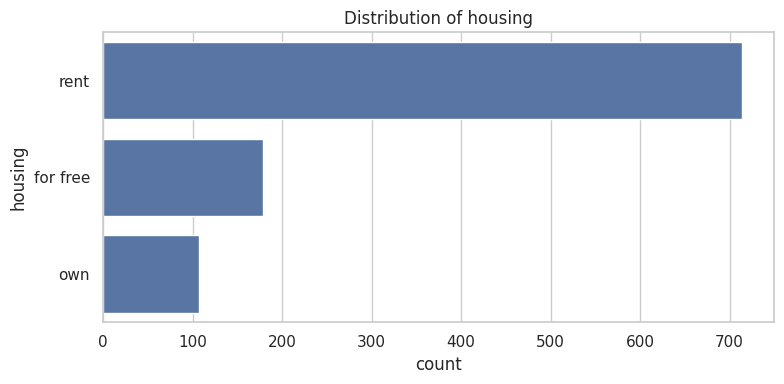

In [ ]:
#  Example categorical distribution: status, savings, housing

cat_cols_example = ["status", "savings", "housing"]

for col in cat_cols_example:
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()


In [ ]:
#  Fairness-oriented quick view:
# Credit risk rate by personal_status_sex and by age group

# Create an age group
df["age_group"] = pd.cut(df["age"], bins=[18, 25, 35, 50, 100],
                         labels=["18-25", "26-35", "36-50", "51+"])

# Bad rate by personal_status_sex
risk_by_sex = (df.groupby("personal_status_sex")["credit_risk"]
                 .apply(lambda x: (x == "bad").mean())
                 .sort_values(ascending=False))
risk_by_sex


,credit_risk
personal_status_sex,
male : divorced/separated,0.400000
female : non-single or male : single,0.351613
female : single,0.271739
male : married/widowed,0.266423


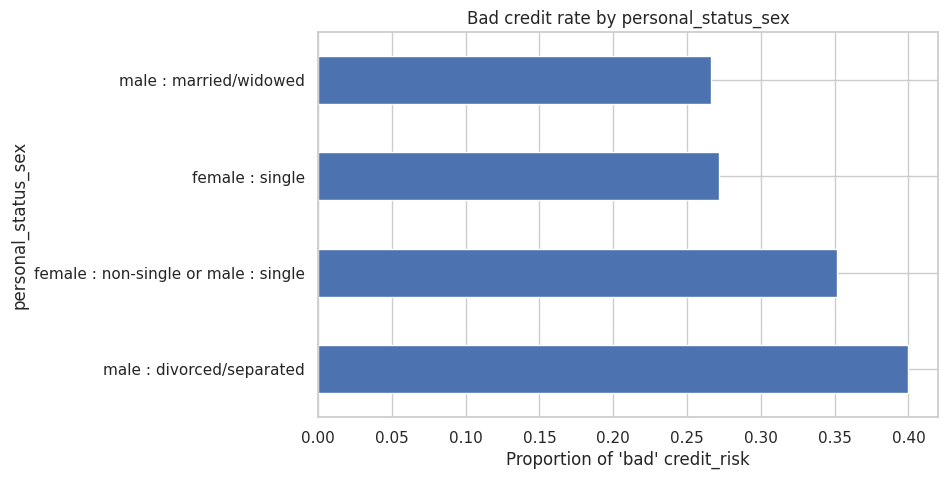

In [ ]:
risk_by_sex.plot(kind="barh")
plt.xlabel("Proportion of 'bad' credit_risk")
plt.title("Bad credit rate by personal_status_sex")
plt.show()


In [ ]:
# Bad rate by age_group
risk_by_age = (df.groupby("age_group")["credit_risk"]
                 .apply(lambda x: (x == "bad").mean()))
risk_by_age


,credit_risk
age_group,
18-25,0.421053
26-35,0.297229
36-50,0.236667
51+,0.274336


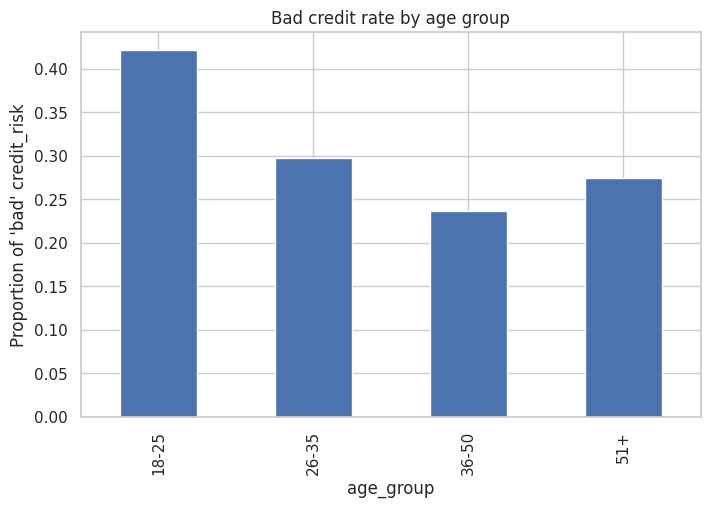

In [ ]:
risk_by_age.plot(kind="bar")
plt.ylabel("Proportion of 'bad' credit_risk")
plt.title("Bad credit rate by age group")
plt.show()


> **Observation:**
> - We can already see if certain groups have higher proportions of bad outcomes.
> - This motivates the later fairness analysis across age and personal_status_sex.


## 8. Methodology Design

###  Problem Type

- **Task:** Supervised binary classification (`good` vs `bad` credit_risk)
- **Data:** Mixed numeric and categorical features
- **Constraints:**
  - Asymmetric misclassification cost
  - Fairness considerations (age, personal_status_sex)
  - Need for interpretable explanations

###  Models Considered

We will initially consider three baseline model families:

1. **Logistic Regression**
   - Interpretable baseline
   - Often used in traditional credit scoring
2. **Random Forest**
   - Non-linear model, handles mixed features well
   - Provides feature importance
3. **Gradient Boosting (e.g., GradientBoostingClassifier)**
   - Strong performance on tabular data
   - Good candidate for best-performing model

###  Preprocessing & Encoding

- Use `ColumnTransformer` with:
  - **One-Hot Encoding** for categorical features
  - **StandardScaler** for selected numeric features
- Train-Test split (e.g., 70% train, 30% test)
- Later, we could compare different encoding schemes if time permits.

###  Evaluation Metrics

1. **Performance metrics**
   - Accuracy
   - AUC-ROC
   - F1-score (especially for 'bad')
2. **Misclassification cost**
   - Cost matrix (example):
     - Cost = 5 for misclassifying **bad** as **good**
     - Cost = 1 for misclassifying **good** as **bad**
3. **Fairness metrics (exploratory)**
   - Difference in bad-rate across groups
   - Confusion matrix breakdown by group (for a chosen model)
4. **Interpretability**
   - Feature importance (Random Forest, Gradient Boosting)
   - Permutation importance
   - SHAP (later extension if environment allows)


In [ ]:
# 9. Train-Test Split and Preprocessing Setup

# Separate features and target
X = df.drop(columns=["credit_risk"])
y = df["credit_risk"]

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)


Categorical columns: ['status', 'credit_history', 'purpose', 'savings', 'employment_duration', 'installment_rate', 'personal_status_sex', 'other_debtors', 'present_residence', 'property', 'other_installment_plans', 'housing', 'number_credits', 'job', 'people_liable', 'telephone', 'foreign_worker']
Numeric columns: ['duration', 'amount', 'age']


In [ ]:
# Train-test split (stratify on target to maintain balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((700, 21), (300, 21))

In [ ]:
# Define preprocessing pipeline

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)


## 10. Baseline Models – Implementation and Evaluation
We now build three pipelines:

1. Logistic Regression  
2. Random Forest  
3. Gradient Boosting  

Each pipeline includes the **same preprocessing steps** for a fair comparison.


In [ ]:
# Logistic Regression Pipeline

log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]  # probability of 'good' (depending on encoder)

print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1-score (macro):", f1_score(y_test, y_pred_lr, average="macro"))
print("AUC-ROC:", roc_auc_score((y_test == "bad").astype(int),
                                (y_pred_lr == "bad").astype(int)))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Performance:
Accuracy: 0.78
F1-score (macro): 0.7141372141372141
AUC-ROC: 0.7000000000000001

Classification Report:
              precision    recall  f1-score   support

         bad       0.68      0.50      0.58        90
        good       0.81      0.90      0.85       210

    accuracy                           0.78       300
   macro avg       0.74      0.70      0.71       300
weighted avg       0.77      0.78      0.77       300



In [ ]:
#  Random Forest Pipeline

rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200, random_state=42, class_weight=None
    ))
])

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1-score (macro):", f1_score(y_test, y_pred_rf, average="macro"))
print("AUC-ROC:", roc_auc_score((y_test == "bad").astype(int),
                                (y_pred_rf == "bad").astype(int)))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Performance:
Accuracy: 0.7666666666666667
F1-score (macro): 0.6600621600621601
AUC-ROC: 0.6460317460317461

Classification Report:
              precision    recall  f1-score   support

         bad       0.74      0.34      0.47        90
        good       0.77      0.95      0.85       210

    accuracy                           0.77       300
   macro avg       0.75      0.65      0.66       300
weighted avg       0.76      0.77      0.74       300



In [ ]:
#  Gradient Boosting Pipeline

gb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", GradientBoostingClassifier(random_state=42))
])

gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

print("Gradient Boosting Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("F1-score (macro):", f1_score(y_test, y_pred_gb, average="macro"))
print("AUC-ROC:", roc_auc_score((y_test == "bad").astype(int),
                                (y_pred_gb == "bad").astype(int)))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Performance:
Accuracy: 0.78
F1-score (macro): 0.7040181774695049
AUC-ROC: 0.6873015873015873

Classification Report:
              precision    recall  f1-score   support

         bad       0.71      0.46      0.55        90
        good       0.80      0.92      0.85       210

    accuracy                           0.78       300
   macro avg       0.75      0.69      0.70       300
weighted avg       0.77      0.78      0.76       300



## 11. Misclassification Cost Analysis

We use a simple **cost matrix**:

- Cost = 5 for misclassifying **bad → good** (false negative for 'bad')
- Cost = 1 for misclassifying **good → bad** (false positive for 'good')

We compute the total cost for each model.


In [ ]:
def misclassification_cost(y_true, y_pred, cost_bad_as_good=5, cost_good_as_bad=1):
    """
    Compute total misclassification cost based on:
    - cost_bad_as_good: cost of predicting 'good' for a 'bad' case
    - cost_good_as_bad: cost of predicting 'bad' for a 'good' case
    """
    cm = confusion_matrix(y_true, y_pred, labels=["good", "bad"])
    # cm structure:
    #            pred_good  pred_bad
    # true_good     cm[0,0]   cm[0,1]
    # true_bad      cm[1,0]   cm[1,1]
    good_as_bad = cm[0,1]
    bad_as_good = cm[1,0]
    total_cost = cost_good_as_bad * good_as_bad + cost_bad_as_good * bad_as_good
    return total_cost, cm

for name, preds in [
    ("Logistic Regression", y_pred_lr),
    ("Random Forest", y_pred_rf),
    ("Gradient Boosting", y_pred_gb),
]:
    cost, cm = misclassification_cost(y_test, preds)
    print(f"{name}:")
    print("  Confusion matrix (rows: true [good,bad], cols: pred [good,bad]):")
    print(cm)
    print("  Total cost (FN bad=5, FP good=1):", cost)
    print()


Logistic Regression:
  Confusion matrix (rows: true [good,bad], cols: pred [good,bad]):
[[189  21]
 [ 45  45]]
  Total cost (FN bad=5, FP good=1): 246

Random Forest:
  Confusion matrix (rows: true [good,bad], cols: pred [good,bad]):
[[199  11]
 [ 59  31]]
  Total cost (FN bad=5, FP good=1): 306

Gradient Boosting:
  Confusion matrix (rows: true [good,bad], cols: pred [good,bad]):
[[193  17]
 [ 49  41]]
  Total cost (FN bad=5, FP good=1): 262



## 12. Basic Fairness Exploration

We explore whether models behave differently across:

- **Age groups**
- **personal_status_sex**



In [ ]:
def group_bad_rate(y_true, y_pred, group_series, group_name="group"):
    """Compute bad prediction rate per group."""
    df_temp = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        group_name: group_series
    })
    # predicted bad rate by group
    rate = (df_temp.groupby(group_name)["y_pred"]
            .apply(lambda x: (x == "bad").mean()))
    return rate

# Example: Using the Random Forest predictions
age_group_test = df.loc[y_test.index, "age_group"]
sex_test = df.loc[y_test.index, "personal_status_sex"]

bad_rate_by_age_rf = group_bad_rate(y_test, y_pred_rf, age_group_test, "age_group")
bad_rate_by_sex_rf = group_bad_rate(y_test, y_pred_rf, sex_test, "personal_status_sex")

bad_rate_by_age_rf, bad_rate_by_sex_rf


(age_group
 18-25    0.267857
 26-35    0.152000
 36-50    0.076087
 51+      0.037037
 Name: y_pred, dtype: float64,
 personal_status_sex
 female : non-single or male : single    0.235955
 female : single                         0.093750
 male : divorced/separated               0.266667
 male : married/widowed                  0.085366
 Name: y_pred, dtype: float64)

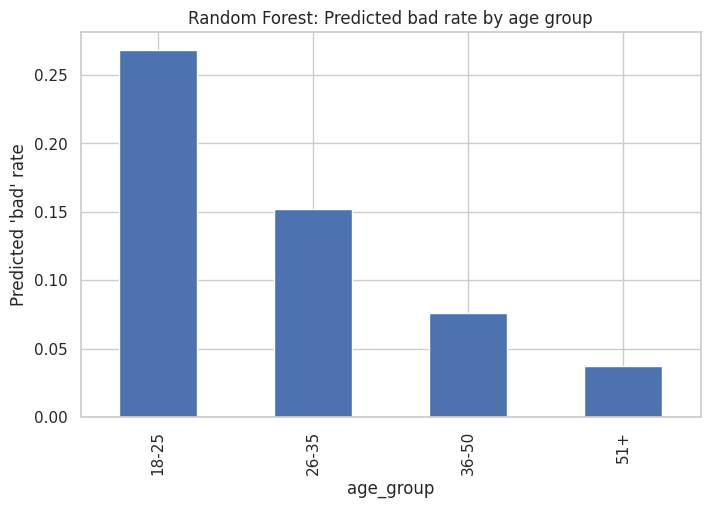

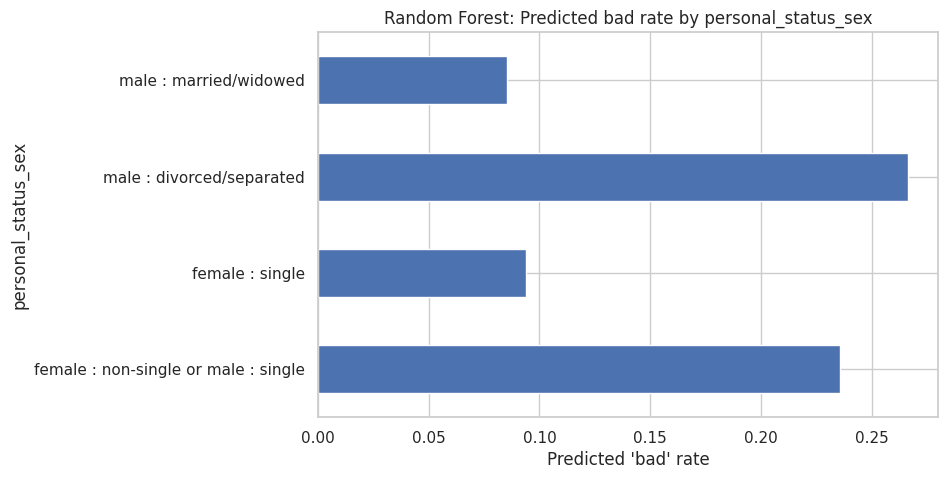

In [ ]:
bad_rate_by_age_rf.plot(kind="bar")
plt.ylabel("Predicted 'bad' rate")
plt.title("Random Forest: Predicted bad rate by age group")
plt.show()

bad_rate_by_sex_rf.plot(kind="barh")
plt.xlabel("Predicted 'bad' rate")
plt.title("Random Forest: Predicted bad rate by personal_status_sex")
plt.show()


> These plots can highlight potential fairness issues if some groups are predicted as 'bad' at much higher rates.
> A deeper fairness analysis (e.g. equal opportunity, demographic parity) will also be added.


## 14. Hyperparameter Tuning (Example for Random Forest)

We perform a simple `RandomizedSearchCV` to search over a small hyperparameter space for the Random Forest model and compare performance.


In [ ]:
#  Hyperparameter tuning for Random Forest (small example)

rf_base_estimator = RandomForestClassifier(random_state=42)

rf_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_base_estimator)
])

param_dist = {
    "model__n_estimators": [100, 200, 300, 500],
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
}

rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="f1_macro",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train, y_train)

print("Best params:", rf_search.best_params_)
print("Best CV f1_macro:", rf_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'model__n_estimators': 300, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_depth': None}
Best CV f1_macro: 0.6016764789733842


In [ ]:
#  Evaluate tuned RF on test set

best_rf = rf_search.best_estimator_

y_pred_rf_tuned = best_rf.predict(X_test)

print("Tuned Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_tuned))
print("F1-score (macro):", f1_score(y_test, y_pred_rf_tuned, average="macro"))
print("AUC-ROC:", roc_auc_score((y_test == "bad").astype(int),
                                (y_pred_rf_tuned == "bad").astype(int)))

cost_tuned, cm_tuned = misclassification_cost(y_test, y_pred_rf_tuned)
print("Misclassification cost (tuned RF):", cost_tuned)
print("Confusion matrix:\n", cm_tuned)


Tuned Random Forest Performance:
Accuracy: 0.77
F1-score (macro): 0.6554077674751544
AUC-ROC: 0.642063492063492
Misclassification cost (tuned RF): 313
Confusion matrix:
 [[202   8]
 [ 61  29]]
